## Problem 1: PyPy's Pizzeria

Congratulations! Due to your success in determining which pizza-making function calls are valid on Homework 1, you have been put in charge of the codebase of PyPy's Pizzeria, a fast-growing chain. Unfortunately, the previous backend engineer didn't know anything about Numpy. This was fine when there was only PyPy's Pizzeria, but their code base simply can't handle 100000 orders coming in at once!

Using all the techniques we discussed in class **other than njit** (profiling to identify bottlenecks -> vectorization + reducing function calls), speed up the pizza-making code so that the combined runtime of the functions take_orders(n=100000) and compute_overhead(orders) runs in under 1 second. **Note that the sample output is currently for 10k orders - do not attempt to run the code for 100k orders until it is significantly optimized.** You don't have to preserve anything about the formatting of the internal variables (e.g. take_orders can return whatever you like) as long as the overall result of the code is the same.

In [32]:
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
random.seed(6)

toppings = ["pepperoni", "sausage", "ham", "chicken", "mushrooms", "pineapple", "peppers", "spinach", "onion", "olives", "extra cheese", "extra sauce"]
topping_probs = [.3, .4, .2, .3, .6, .05, .2, .25, .45, .3, .35, .35]
topping_costs = [2.0, 1.5, 3.0, 2.5, 1.0, 1.0, 1.5, 1.5, 1.0, 2.0, 3.0, 2.5]

prob_deepdish = .6 #deal with it
prob_detroitstyle = .1

base_cost = 10.0

def take_orders(n_customers=10000):
    #returns a list of each pizza's toppings, type, cost, and bake time

    orders = []
    for i in range(n_customers):
        order_list = []
        toppings_list = []

        for topping in toppings:
            topping_rand = random.random()
            if topping_rand < topping_probs[toppings.index(topping)]:
                toppings_list.append(topping)
        order_list.append(toppings_list)

        #type
        type_rand = random.random()
        if type_rand < prob_deepdish:
            order_list.append("Deep dish")
        elif type_rand < prob_deepdish + prob_detroitstyle:
            order_list.append("Detroit style")
        else:
            order_list.append("New York style")

        #cost - intentionally written very badly
        cost = base_cost
        for topping in toppings:
            if topping in toppings_list:
                topping_index = toppings.index(topping)
                cost += topping_costs[topping_index]

        #deluxe surcharge
        if len(toppings_list) > 2:
            cost += 2.0

        order_list.append(cost)
        
        #bake times
        if order_list[1] == "Deep dish":
            order_list.append(45)
        elif order_list[1] == "Detroit style":
            order_list.append(25)
        else:
            order_list.append(10)

        orders.append(order_list)
    return orders


def compute_overhead(n_orders):
    n = len(n_orders)
    revenue = 0

    toppings_used = [0]*len(toppings)
    for order_i in n_orders:
        revenue += order_i[-2]
        for topping in toppings:
            if topping in order_i[0]:
                toppings_used[toppings.index(topping)] += 1

    print(f"Total revenue from {n} customers: {revenue:.2f}.")
    print("Total ingredients used:")
    for topping in toppings:
        print(f"{toppings_used[toppings.index(topping)]} {topping}.")
    
    #make a histogram of the numbers of different types of pizzas ordered
    same_pizzas = []
    for order_i in n_orders:
        num_same = 0
        for order_j in n_orders:
            for order_component_idx in range(len(order_i)):
                if order_i[order_component_idx] != order_j[order_component_idx]:
                    break
                num_same += 1
        same_pizzas.append(num_same)

    plt.hist(same_pizzas)
    plt.show()
    
    


Total revenue from 10000 customers: 183479.00.
Total ingredients used:
3014 pepperoni.
3861 sausage.
2031 ham.
2930 chicken.
5927 mushrooms.
506 pineapple.
1929 peppers.
2475 spinach.
4504 onion.
3026 olives.
3505 extra cheese.
3435 extra sauce.


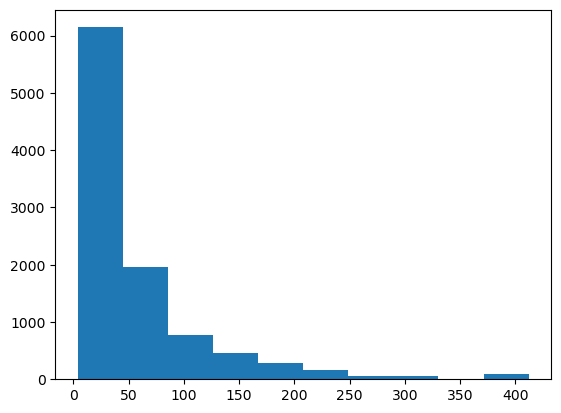

22.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [34]:
%%timeit -n 1 -r 1

orders = take_orders(10000)
compute_overhead(orders)

## Problem 2: Hmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm

As discussed in minimal mathematical detail at the Advance, my work heavily uses the Hidden Markov Model (HMM). The following code implements a generic HMM in not-very-optimized form, as well as providing some short test cases with which to benchmark its speed.

Inspired by my life circa May 2022, your task is to optimize the code! 

To do this effectively, learning a thing or two about HMMs may be of use (or not - sometimes it can be more effective to just treat code as code and optimize away). [This page](https://www.cs.ubc.ca/~murphyk/Bayes/rabiner.pdf) is the standard introduction to HMMs - readable but concise. Only sections I-III are relevant (you can stop when you get to "IV - Types of HMMs" on page 10). In addition, the Wikipedia page for HMMs is pretty good. I use the notation from [the "weather guessing game" section](https://en.wikipedia.org/wiki/Hidden_Markov_model#Weather_guessing_game) to contextualize the benchmark samples.

Profile, vectorize, reduce function calls, numba, repeat to your heart's content!

Once you feel like your code is reasonably optimized, run the final cell, which does 50000 iterations.

Note that if you choose to do this in a jupyter notebook, you can still use snakeviz with the
%load_ext snakeviz and %%snakeviz -t commands.

Also note that numba is of course useful but not the only way to achieve significant speedups - my optimized code is roughly 3x faster than just adding @njit to everything.

Good luck! This will take a while but trust me it's worth it - optimizing my pop-gen HMM was basically how I learned about all of this stuff.

In [ ]:
import numpy as np
from tqdm.notebook import tqdm

#equations 18-21 in Rabiner
def forward_algo(A_matrix, B_matrix, pi, O):
    T = O.shape[0]
    alphas = np.zeros((pi.shape[0], T))
    alphas[:, 0] = pi * B_matrix[:, O[0]]
    for t in np.arange(1, T):
        for j in np.arange(alphas.shape[0]):
            alphas[j, t] = np.sum(A_matrix[:, j] * alphas[:, t - 1]) * B_matrix[j, O[t]]
    return alphas

#equations 23-25 in Rabiner
def backward_algo(A_matrix, B_matrix, pi, O):
    T = O.shape[0]
    betas = np.zeros((pi.shape[0], T))
    betas[:, -1] = 1
    for t in np.arange(1, T):
        for i in np.arange(betas.shape[0]):
            betas[i, -(t + 1)] = np.sum(A_matrix[i, :] * B_matrix[:, O[-t]] * betas[:, -t])
    return betas

#equations 26-28 in Rabiner
def compute_gammas(alphas, betas):
    gammas = alphas * betas
    gammas /= np.sum(gammas, axis=0)
    assert np.all(np.isclose(np.sum(gammas, axis=0), 1))
    return gammas

#equations 36-38 in Rabiner
def compute_xis(alphas, betas, A_matrix, B_matrix, O):
    xis = np.zeros((alphas.shape[0], alphas.shape[0], alphas.shape[1] - 1))
    for t in np.arange(alphas.shape[1] - 1):
        for i in np.arange(alphas.shape[0]):
            for j in np.arange(alphas.shape[0]):
                xis[i, j, t] = alphas[i, t] * A_matrix[i, j] * B_matrix[j, O[t + 1]] * betas[j, t + 1]
    xis /= np.sum(np.sum(xis, axis=0),axis=0)
    return xis

#equations 40a-c in Rabiner
def update_params(gammas, xis, A_matrix, B_matrix, O, pi):
    pi_new = gammas[:, 0]
    A_matrix_new = np.zeros_like(A_matrix)
    B_matrix_new = np.zeros_like(B_matrix)
    for j in np.arange(A_matrix_new.shape[0]):
        A_matrix_new[:, j] = np.sum(xis[:, j, :], axis=1) / np.sum(gammas[:, :-1], axis=1)

    for k in np.arange(B_matrix_new.shape[1]):
        obs_mask = O == k
        B_matrix_new[:, k] = np.sum(gammas[:, obs_mask], axis=1) / np.sum(gammas, axis=1)

    return pi_new, A_matrix_new, B_matrix_new



### these two functions are probably less optimizable, since they're just calling the above functions

#defines the forward/backward -> gamma + xis -> parameter re-estimation loop
def run_one_iter(A_matrix, B_matrix, pi, O):
    alphas = forward_algo(A_matrix, B_matrix, pi, O)
    betas = backward_algo(A_matrix, B_matrix, pi, O)
    gammas = compute_gammas(alphas, betas)
    xis = compute_xis(alphas, betas, A_matrix, B_matrix, O)
    assert np.all(np.isclose(np.sum(xis, axis=1), gammas[:, :-1]))
    pi_new, A_matrix_new, B_matrix_new = update_params(gammas, xis, A_matrix, B_matrix, O, pi)
    return pi_new, A_matrix_new, B_matrix_new, np.sum(alphas[:, -1])

#iterates run_one_iter, checks if the likelihood has converged, repeats
def run_hmm(A_init, B_init, pi_init, O, tol, max_iter):
    pi, A, B = pi_init, A_init, B_init
    itercount = 0
    likelihood = -np.inf
    while itercount < max_iter:
        pi, A, B, ll_new = run_one_iter(A, B, pi, O)
        if ll_new - likelihood < tol:
            return pi, A, B, ll_new
        likelihood = ll_new
        itercount += 1
    print("failed to converge!")
    return None, None, None, None

In [ ]:
#initial distribution of the hidden variable - is day 1 sunny, cloudy, or rainy?
pi_init = np.array([0.1, 0.1, 0.8])

#initial transition matrix - P([sunny -> sunny, sunny -> cloudy, sunny -> rainy], etc)
A_init = np.array([[0.5, 0.4, 0.1], [0.3, 0.4, 0.3], [0.1, 0.45, 0.45]])

#initial emission matrix - P([activity 1, activity 2, activity 3...]|sunny, etc)
B_init = np.array([[.2, .1, .3, .25, .15], [.4, .15, .3, .1, .05], [0.6, .2, .198, 0.001, 0.001]])

rng = np.random.default_rng(1)

#set up a random series of fake observations
obs_array = rng.choice([0,1,2,3,4], (1000, 250), replace=True)
tol = 1e-8
max_iter = 100

for i in tqdm(np.arange(obs_array.shape[0])):
    pi_final, A_final, B_final, ll_final = run_hmm(A_init, B_init, pi_init, obs_array[i, :], tol, max_iter)

In [ ]:
### final test - don't run initially it will be pretty slow
obs_array = rng.choice([0,1,2,3,4], (50000, 250), replace=True)
tol = 1e-8
max_iter = 100

for i in tqdm(np.arange(obs_array.shape[0])):
    pi_final, A_final, B_final, ll_final = run_hmm(A_init, B_init, pi_init, obs_array[i, :], tol, max_iter)